In [1]:
import pixelator

import os
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pixelator.plot import molecule_rank_plot, cell_count_plot, scatter_umi_per_upia_vs_tau
from pixelator import simple_aggregate

import scanpy as sc


/home/eitan/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/eitan/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/eitan/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/eitan/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/eitan/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:

TODO: 
1. Understand best practice for order between normalization and filtering steps. Double normalization? (CLR/DSB + pp.normalize_total?)
2. Continue scanpy tutorials
3. Continue scvi tutorials


In [2]:
# Setup
DATA_DIR = Path('./datasets')

# Dataset: https://software.pixelgen.com/datasets/technote-mpx-v1-vs-v2


# We use only the V2 non stimulated cells
# FILENAMES = [
#     "Sample05_V2_PBMC_r1.layout.dataset.pxl",
#     "Sample06_V2_PBMC_r2.layout.dataset.pxl",
# ]

# COMBINED_FILENAME = "combined_resting_data.pxl"

# combined_path = DATA_DIR / COMBINED_FILENAME
# # if os.path.exists(combined_path):
# #     pg_data = pixelator.read(combined_path)
# baseurl = "https://pixelgen-technologies-datasets.s3.eu-north-1.amazonaws.com/mpx-datasets/pixelator/0.18.x/technote-v1-vs-v2-immunology-II"
# for filename in FILENAMES:
#     !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} "{baseurl}/{filename}"

# pg_data = pixelator.simple_aggregate(
#     ["resting_r1", "resting_r2", ], [pixelator.read(DATA_DIR / filename) for filename in FILENAMES]
# )
# pg_data.save(combined_path, force_overwrite=True)

# Sample 1 of the V2 kit (non stimulated cells)
pg_data = pixelator.read(DATA_DIR / "Sample05_V2_PBMC_r1.layout.dataset.pxl")
pg_data.adata.obs['sample'] = 'resting_r1'
adata = pg_data.adata
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True, var_type='proteins')
adata.obs

/home/eitan/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_elem from `anndata.experimental` is deprecated. Import anndata.io.read_elem instead.
  warnings.warn(msg, FutureWarning)


,pixels,a_pixels,b_pixels,antibodies,molecules,reads,mean_reads_per_molecule,median_reads_per_molecule,mean_b_pixels_per_a_pixel,median_b_pixels_per_a_pixel,...,mean_molecules_per_a_pixel,median_molecules_per_a_pixel,leiden,tau_type,tau,sample,n_proteins_by_counts,log1p_n_proteins_by_counts,total_counts,log1p_total_counts
component,,,,,,,,,,,,,,,,,,,,,
RCVCMP0000000,5833,3749,2084,79,35040,114108,3.256507,3.0,2.794345,2.0,...,9.346492,5.0,0,normal,0.935262,resting_r1,79,4.382027,35040,10.464274
RCVCMP0000001,4769,3338,1431,79,33399,107689,3.224318,3.0,2.933493,2.0,...,10.005692,5.0,1,normal,0.939779,resting_r1,79,4.382027,33399,10.416311
RCVCMP0000002,4227,2724,1503,78,34376,113349,3.297330,3.0,3.825624,3.0,...,12.619677,7.5,0,normal,0.922382,resting_r1,78,4.369448,34376,10.445143
RCVCMP0000004,3285,2159,1126,79,13859,42368,3.057075,3.0,2.352478,2.0,...,6.419176,3.0,2,normal,0.938652,resting_r1,79,4.382027,13859,9.536762
RCVCMP0000005,9958,6413,3545,79,43839,136302,3.109149,3.0,2.397318,2.0,...,6.835958,3.0,3,normal,0.945426,resting_r1,79,4.382027,43839,10.688302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCVCMP0003226,4556,3070,1486,78,27696,86200,3.112363,3.0,2.829642,2.0,...,9.021498,5.0,6,normal,0.963925,resting_r1,78,4.369448,27696,10.229079
RCVCMP0003903,1493,1156,337,77,6151,20833,3.386929,3.0,1.844291,1.0,...,5.320934,2.0,6,normal,0.961566,resting_r1,77,4.356709,6151,8.724533
RCVCMP0004008,578,376,202,72,2333,7063,3.027432,3.0,2.412234,2.0,...,6.204787,3.0,6,normal,0.940160,resting_r1,72,4.290459,2333,7.755339


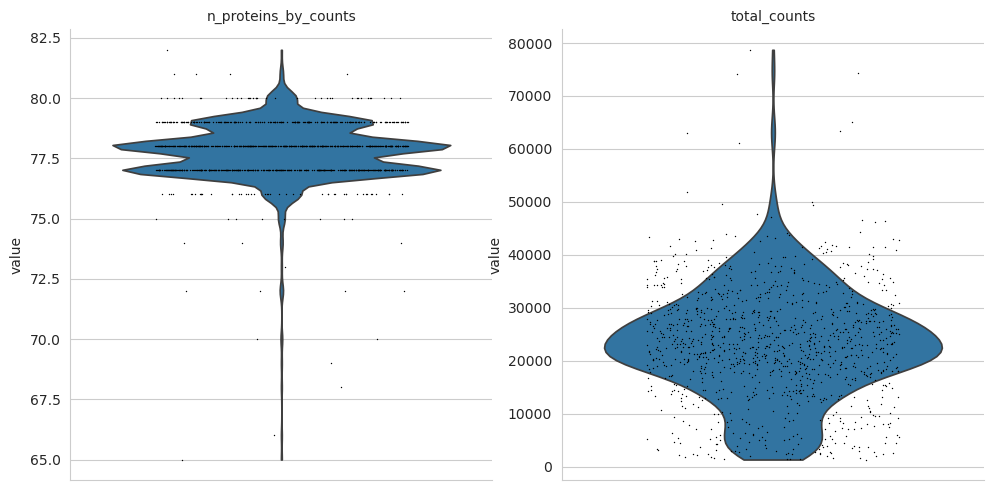

In [3]:
sc.pl.violin(
    adata,
    ["n_proteins_by_counts", "total_counts",],
    jitter=0.3,
    multi_panel=True,
)

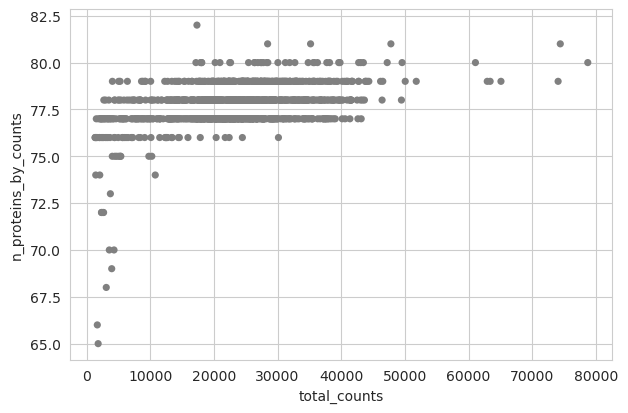

In [4]:
sc.pl.scatter(adata, "total_counts", "n_proteins_by_counts")

In [5]:
print(pg_data.adata)
print(pg_data.adata.X)

AnnData object with n_obs × n_vars = 1125 × 84
    obs: 'pixels', 'a_pixels', 'b_pixels', 'antibodies', 'molecules', 'reads', 'mean_reads_per_molecule', 'median_reads_per_molecule', 'mean_b_pixels_per_a_pixel', 'median_b_pixels_per_a_pixel', 'mean_a_pixels_per_b_pixel', 'median_a_pixels_per_b_pixel', 'a_pixel_b_pixel_ratio', 'mean_molecules_per_a_pixel', 'median_molecules_per_a_pixel', 'leiden', 'tau_type', 'tau', 'sample', 'n_proteins_by_counts', 'log1p_n_proteins_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'antibody_count', 'components', 'antibody_pct', 'nuclear', 'control', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'neighbors', 'tau_thresholds', 'umap', 'version'
    obsm: 'X_umap', 'clr', 'log1p'
    obsp: 'connectivities', 'distances'
[[4690  349  509 ...   14   22   15]
 [3379   94  262 ...   24   22   12]
 [3070   39  202 ...   17   31   17]
 ...
 [ 329    8   21 ...    1    5    

/tmp/ipykernel_1030354/144373203.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
/home/eitan/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/pixelator/plot/__init__.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  edge_rank_df["rank"] = edge_rank_df.groupby([group_by])["molecules"].rank(


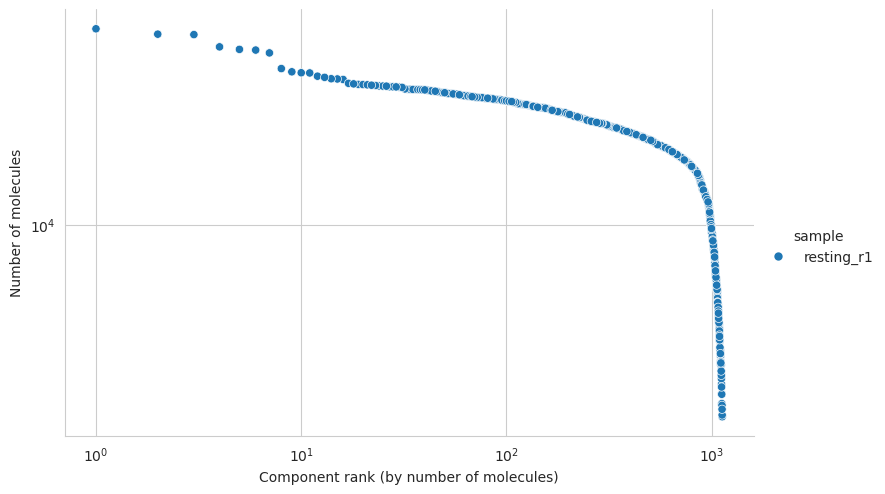

In [6]:
molecule_rank_df = adata.obs[["sample", "molecules"]].copy()
molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
    ascending=False, method="first"
)
fig, ax = molecule_rank_plot(molecule_rank_df, group_by="sample")

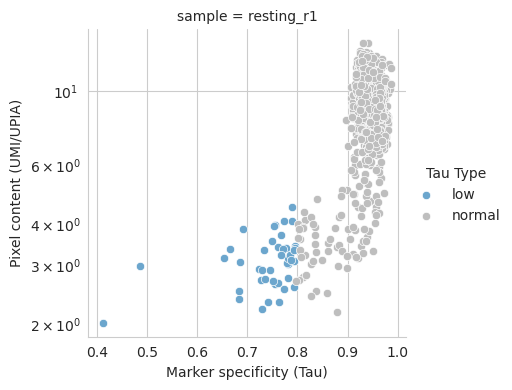

In [7]:
tau_metrics_df = adata.obs[["sample", "tau", "mean_molecules_per_a_pixel", "tau_type"]]
tau_metrics_df = tau_metrics_df.rename(columns={"mean_molecules_per_a_pixel": "umi_per_upia"})


fig, ax = scatter_umi_per_upia_vs_tau(tau_metrics_df, group_by="sample")

In [8]:
components_to_keep = adata[
    (adata.obs["molecules"] >= 10000)
    & (adata.obs["tau_type"] == "normal")
    & (adata.obs['a_pixels'] <= 10000)  # My change - removing a single outlier
].obs.index

pg_data = pg_data.filter(components=components_to_keep)
# os.remove(DATA_DIR/ "Sample06_V2_PBMC_r2.layout.dataset_FILTERED.pxl")
# pg_data.save(DATA_DIR/ "Sample06_V2_PBMC_r2.layout.dataset_FILTERED.pxl", force_overwrite=True)
adata = pg_data.adata

In [9]:
# Single outlier with extreme measures of a_pixel
print((adata.obs['a_pixels'] > 20000).sum())
adata.obs = adata.obs.drop(adata.obs[adata.obs['a_pixels'] > 20000].index)

0


True


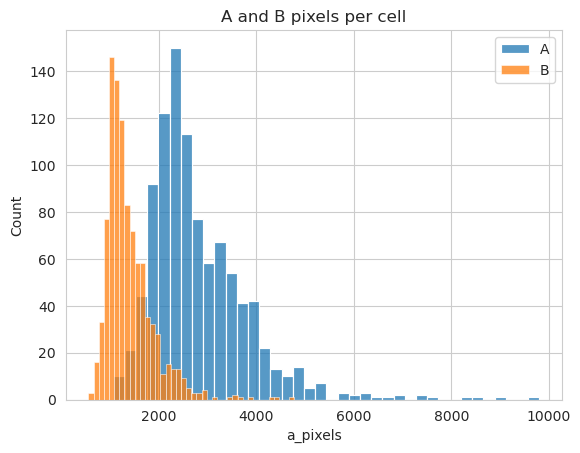

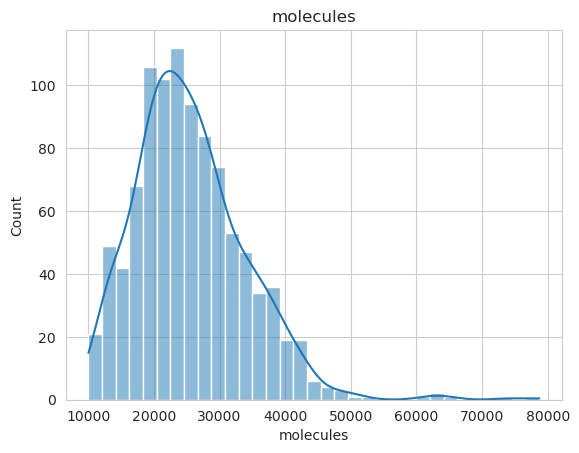

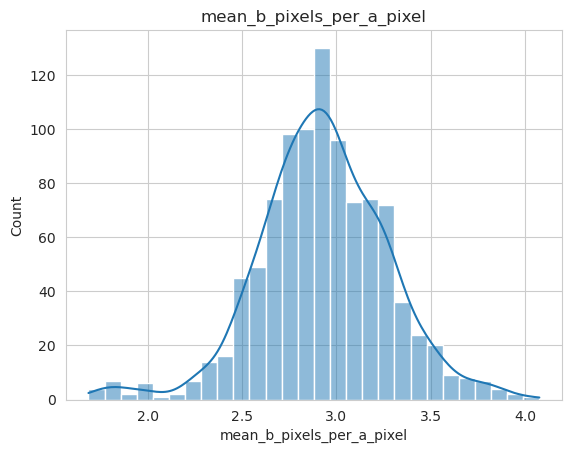

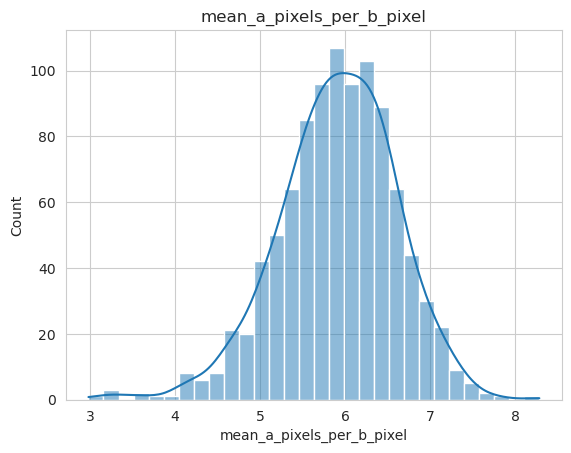

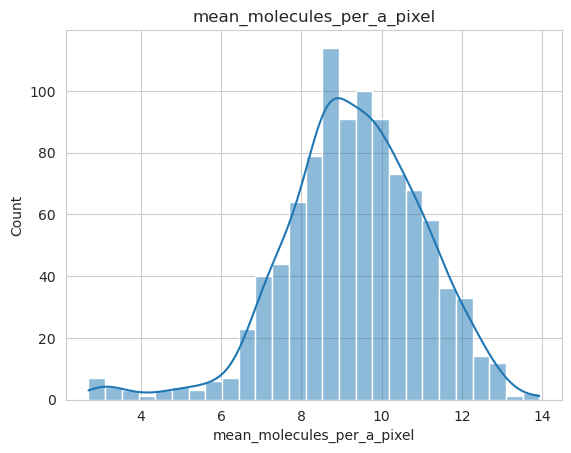

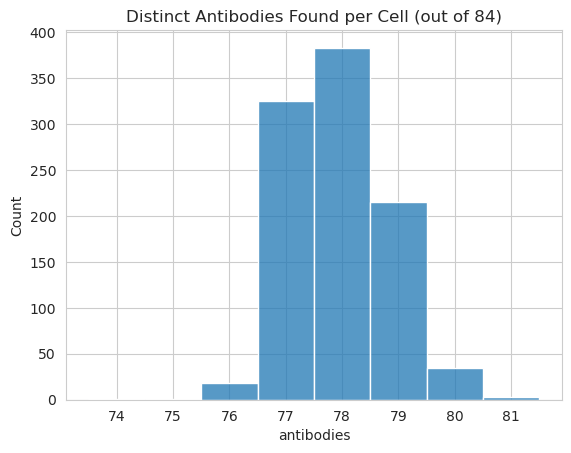

In [10]:
hist_vars = ['a_pixels', 'b_pixels', 'molecules', 'mean_b_pixels_per_a_pixel', 'mean_a_pixels_per_b_pixel', 'mean_molecules_per_a_pixel', 'antibodies']
print(all(adata.obs['pixels'] ==  adata.obs['a_pixels'] + adata.obs['b_pixels']))
for var in hist_vars:
    if var == 'b_pixels':
        continue
    fig, ax = plt.subplots(1)
    if var == 'a_pixels':
        sns.histplot(adata.obs['a_pixels'], ax=ax, label='A')
        sns.histplot(adata.obs['b_pixels'], ax=ax, label='B')
        ax.legend()
        ax.set_title('A and B pixels per cell')
        continue
    if var == 'antibodies':
        sns.histplot(adata.obs['antibodies'], ax=ax, discrete=True)
        ax.set_title('Distinct Antibodies Found per Cell (out of 84)')
        ax.set_xticks(list(range(adata.obs['antibodies'].min(), adata.obs['antibodies'].max() + 1)))
        continue
    sns.histplot(adata.obs[var], kde=True, ax=ax)
    ax.set_title(var)


/tmp/ipykernel_1030354/3094568111.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
/home/eitan/miniconda3/envs/pixelgen-vi/lib/python3.10/site-packages/pixelator/plot/__init__.py:132: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  edge_rank_df["rank"] = edge_rank_df.groupby([group_by])["molecules"].rank(


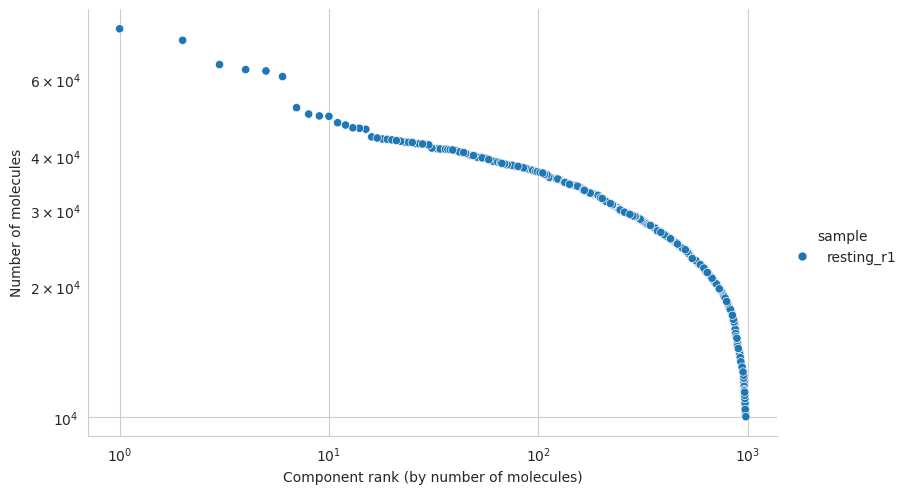

In [11]:
molecule_rank_df = adata.obs[['sample', 'molecules']].copy()
molecule_rank_df["rank"] = molecule_rank_df.groupby(["sample"])["molecules"].rank(
    ascending=False, method="first"
)
fig, ax = molecule_rank_plot(molecule_rank_df, group_by="sample")

<Axes: xlabel='a_pixels', ylabel='mean_b_pixels_per_a_pixel'>

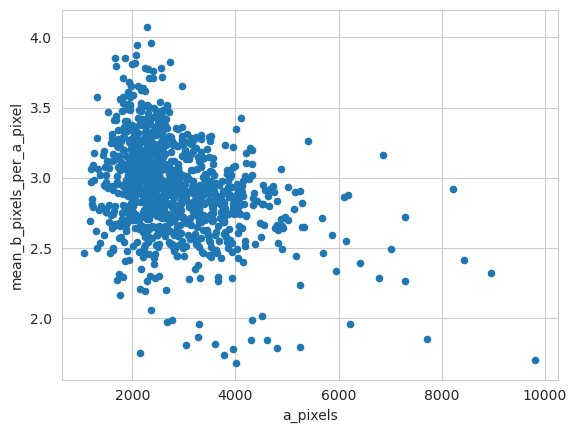

In [12]:
adata.obs = adata.obs.drop(adata.obs[adata.obs['a_pixels'] > 20000].index)
adata.obs.plot.scatter(x='a_pixels', y='mean_b_pixels_per_a_pixel')

In [13]:
antibody_variation_df = pg_data.adata.to_df().aggregate(['mean', 'std']).transpose()
antibody_variation_df['std/mean'] = antibody_variation_df['std'] / antibody_variation_df['mean']

Text(0.5, 1.0, 'Cells per antibody')

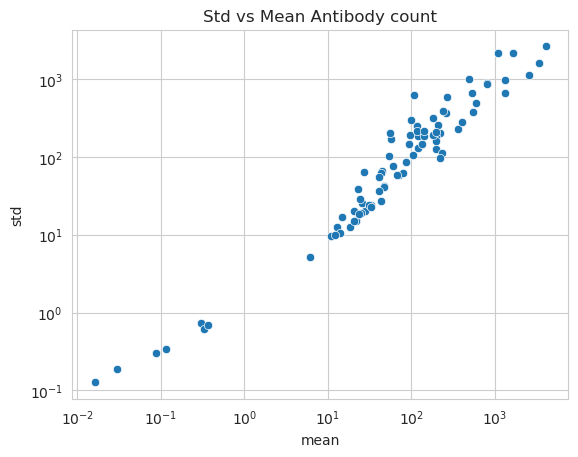

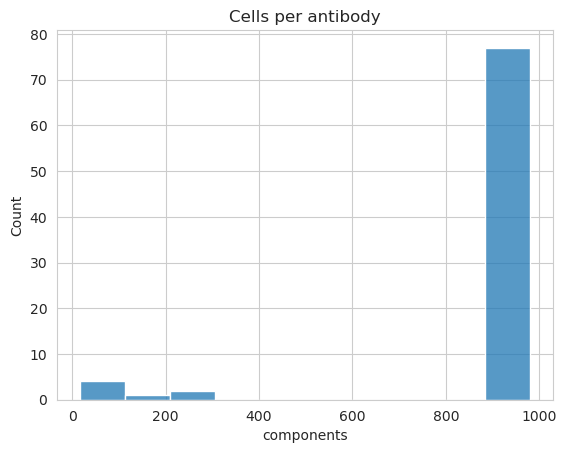

In [14]:
fig, ax = plt.subplots(1)
# sns.histplot(np.log10(adata.var['antibody_count']), ax=ax[0])
# ax[0].set_title('Log10 Total Antibody count')
sns.scatterplot(data=antibody_variation_df, x='mean', y='std')
ax.set_xscale('log')
ax.set_yscale('log')
# sns.histplot(np.log10(adata_df.mean(axis=0)), ax=ax)
ax.set_title('Std vs Mean Antibody count')

# fig, ax = plt.subplots(1)
# sns.histplot(np.log10(adata.var['components']), ax=ax, binwidth=0.25)
# ax.set_title('Log10 cells per antibody')

fig, ax = plt.subplots(1)
sns.histplot(adata.var['components'], ax=ax, binwidth=100)
ax.set_title('Cells per antibody')

# fig, ax = plt.subplots(1)
# antibody_variation = pg_data.adata.X.var(axis=0,)
# sns.histplot(np.log10(antibody_variation), ax=ax)
# ax.set_title('Log10 Antibody Count Variation (across cells)')

In [15]:
# antibody_variation_df.sort_values(by='mean', axis=0, ascending=False, inplace=True)
antibody_variation_df[antibody_variation_df['mean'] < 10].index

Index(['CD123', 'CD180', 'CD191', 'CD192', 'CD335', 'CD39', 'CD58', 'CD94'], dtype='object', name='marker')

In [16]:
# antibody_variation_df.sort_values(by='std', axis=0, ascending=False, inplace=True)
# # var(axis=0).sort_values(ascending=False)
# # antibody_variation_df['']
# print(antibody_variation_df.head(10))
# print(antibody_variation_df.tail(10))

# antibody_variation_df.sort_values(by='std/mean', axis=0, ascending=False, inplace=True)
# print(antibody_variation_df.head(10))
# print(antibody_variation_df.tail(10))



In [17]:
# sns.histplot(adata_df['CD24'])

Text(0.5, 1.0, 'Ab Pairs - Joint Cell Count (Abundance > 10)')

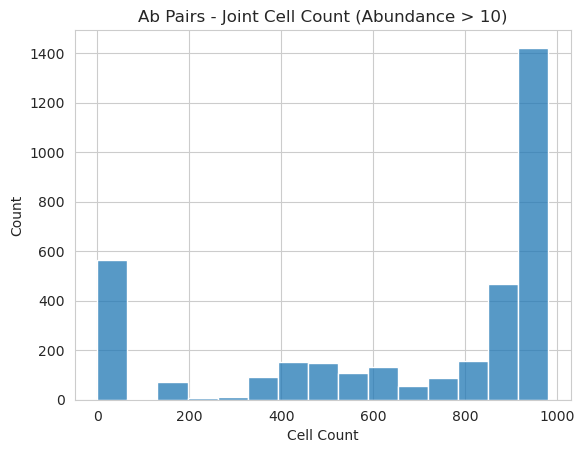

In [18]:
import itertools

adata_df = adata.to_df()
adata_corr = adata_df.corr()
n_antibodies = pg_data.adata.X.shape[1]
antibody_pairs_names = list(itertools.combinations(pg_data.adata.var_names, 2))
antibody_pair_count = pd.DataFrame(index=antibody_pairs_names, columns={'Cell Count': pd.Series(dtype=int), 'Corr': pd.Series(dtype=float)})
abundance_thresh = 10
for i, (ab_1, ab_2) in enumerate(antibody_pairs_names):
    name = (ab_1, ab_2)
    antibody_pair_count.at[name, 'Cell Count'] = len(adata_df[(adata_df[ab_1] > abundance_thresh) & (adata_df[ab_2] > abundance_thresh)])
    antibody_pair_count.at[name, 'Corr'] = adata_corr.loc[ab_1, ab_2]

# ax = sns.kdeplot(antibody_pair_count, x='Cell Count', y='Corr')
# ax.set_title('Ab Pairs - Correlation vs Joint Cell Count (Abundance > 10)')

ax = sns.histplot(antibody_pair_count['Cell Count'])
ax.set_title('Ab Pairs - Joint Cell Count (Abundance > 10)')

# protein_pair_count = pg_data.adata.X.copy()
# antibody_pair_count.sort_values(ascending=False).tail(10)


## DSB and CLR Normalization
DSB normalization should be taking care of "background noise" adding to the marker counts, due to non-specific binding.
However it does not work in all cases, it relies on having positive (=the marker should exist) and negative (=the marker should not exist) cell populations for each (?) marker.

In [19]:
from pixelator.analysis.normalization import dsb_normalize
from pixelator.statistics import clr_transformation

adata.layers['dsb'] = dsb_normalize(adata.to_df(), isotype_controls=["mIgG1", "mIgG2a", "mIgG2b"])
adata.layers['log1p'] = np.log1p(adata.to_df())
adata.layers['clr'] = clr_transformation(adata.to_df(), axis=1)

Text(0.5, 1.0, 'CLR')

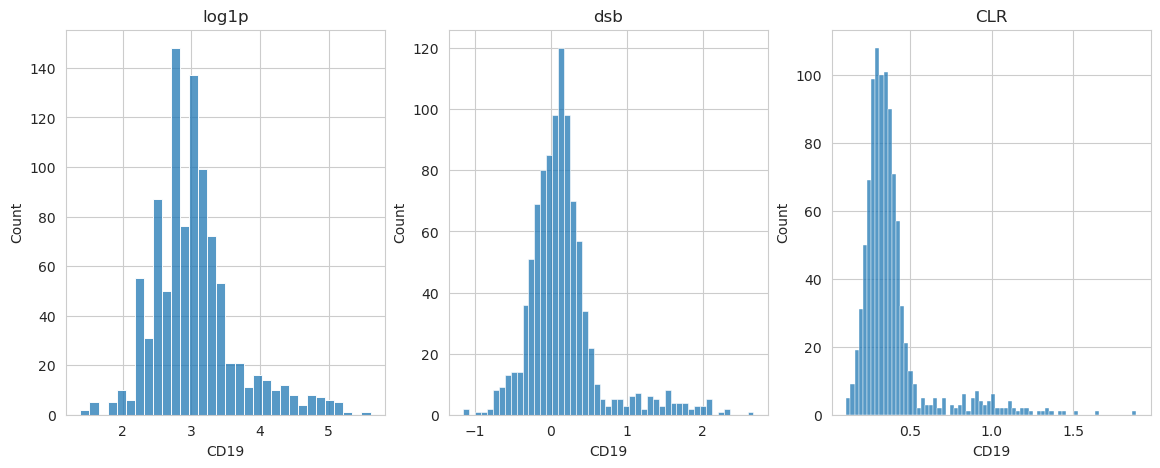

In [20]:
# CD19 marker
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
sns.histplot(data=adata.to_df('log1p'), x='CD19', ax=axes[0])
axes[0].set_title('log1p')
sns.histplot(data=adata.to_df('dsb'), x='CD19', ax=axes[1])
axes[1].set_title('dsb')
sns.histplot(data=adata.to_df('clr'), x='CD19', ax=axes[2])
axes[2].set_title('CLR')

## Key takeaways
1. A large majority of antibodies are present in almost all cells. However some antibodies are present in very low quantities with a mean abundance of less than 10: 'CD123', 'CD94', 'CD192', 'CD335', 'CD58', 'CD39', 'CD191', 'CD180'
2. Most cells have 10K-40K antibodies sequenced
3. Antibody abundance variance grows with mean
4. Antibody pairs could be informative even without spatial information

In [21]:
# TODO: protein abundance cutoff 10K-50K
# TODO: PCA -> Cell types

In [22]:
print(adata.obsm['X_umap'].shape)

(981, 2)


<Axes: >

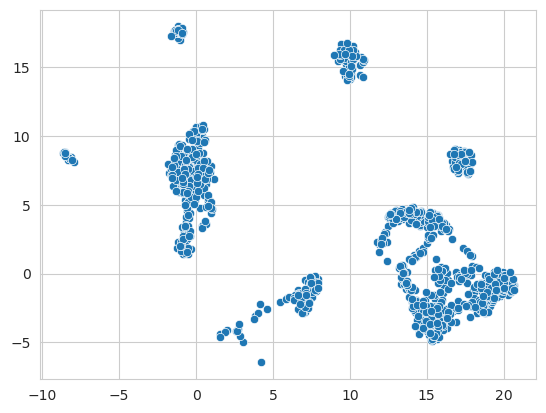

In [23]:
sns.scatterplot(x=adata.obsm['X_umap'][:, 0], y=adata.obsm['X_umap'][:, 1])

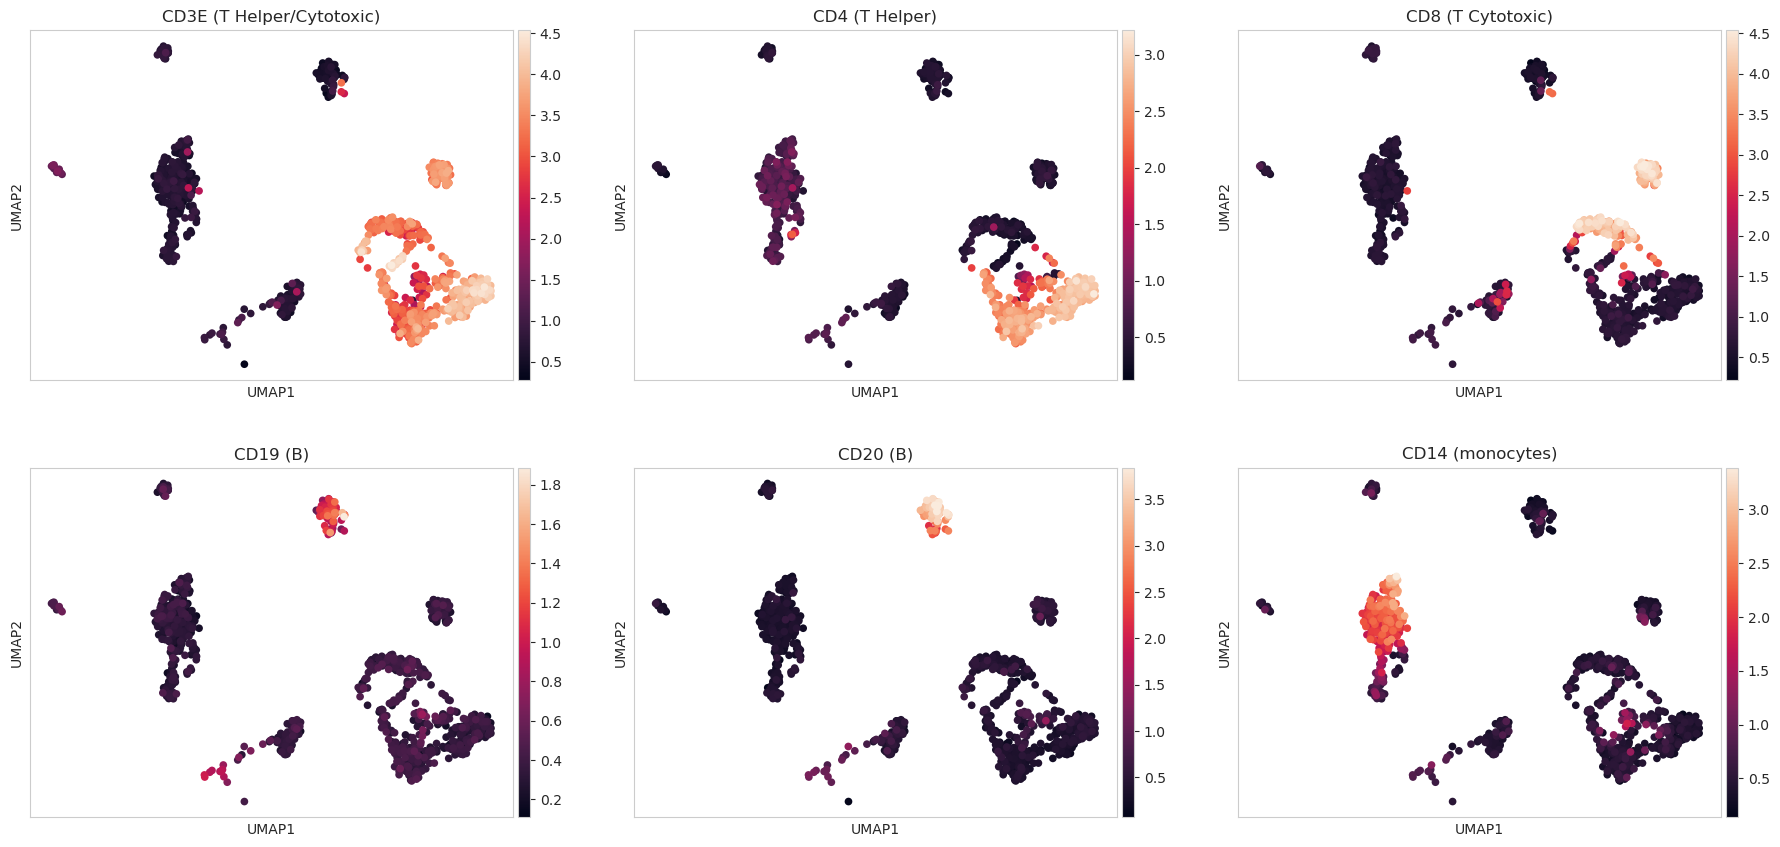

In [25]:
markers_of_interest = ["CD3E", "CD4", "CD8", "CD19", "CD20", "CD14"]
titles = ["CD3E (T Helper/Cytotoxic)", "CD4 (T Helper)", "CD8 (T Cytotoxic)", "CD19 (B)", "CD20 (B)", "CD14 (monocytes)"]
sc.pl.umap(adata, color=markers_of_interest, ncols=3, layer='clr', title=titles)

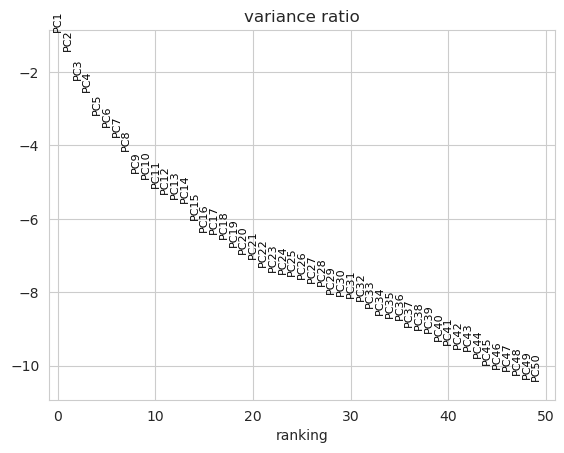

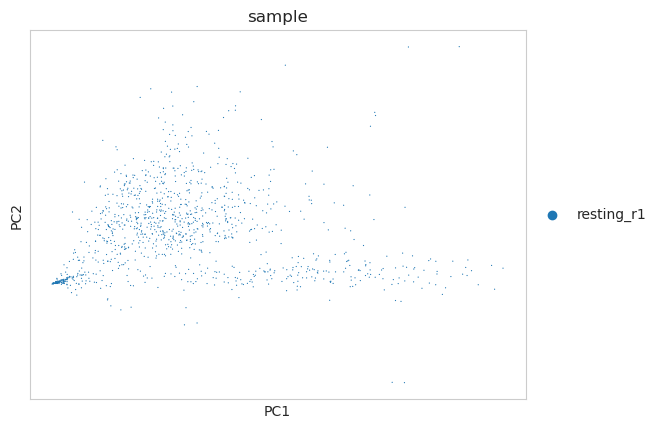

In [ ]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
sc.pl.pca(
    adata,
    color=["sample",],
    dimensions=[(0, 1)],
    size=3,
)

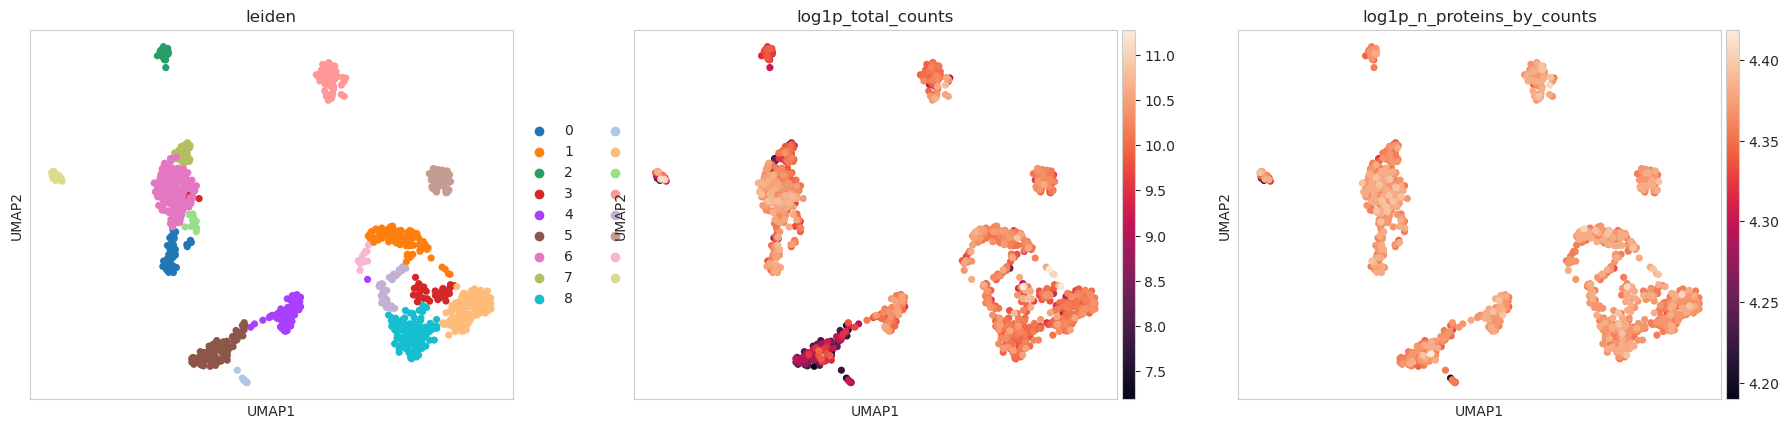

In [ ]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True, var_type='proteins')
sc.pl.umap(adata, color=['leiden', 'log1p_total_counts', 'log1p_n_proteins_by_counts'], ncols=3)

In [ ]:
pg_data.edgelist.head(5)

,upia,upib,umi,marker,sequence,count,unique_molecules_count,component
0,CGGGTTAGTTCATAATTAGCCCATT,ATTGCAGGTCGTTAGACAGATAGTG,CGTCAGTGGG,CD19,ACCAACTT,15,1,RCVCMP0000000
1,CGTGATCAGACAACACGATGTGAGG,GCAGGGAACGACGGGTTTGCGTGGC,GAAGCGTCCT,CD19,ACCAACTT,15,1,RCVCMP0000001
2,CTTTTAGTGTTTTCTATATTTCTTA,CGTTTGTTTTCTGCGAAATTACTGC,TGCGAGGGGG,CD19,ACCAACTT,15,1,RCVCMP0000002
3,ACCCAGTTCTGCTCTGTCACGCAGT,GATGTGGAAATCTAATATGTATACC,GAGTTTGGGA,CD19,ACCAACTT,14,1,RCVCMP0000004
4,TTGGTGTACTTCATTCTGTCGGGTC,AGCGGGGAGCTTGCGGTTTGTACAT,TAGTGGACCA,CD19,ACCAACTT,14,1,RCVCMP0000005


In [ ]:
# # Minimal crashing code

# DATA_DIR = Path('./datasets')

# baseurl = "https://pixelgen-technologies-datasets.s3.eu-north-1.amazonaws.com/mpx-datasets/pixelator/0.18.x/technote-v1-vs-v2-immunology-II"

# # !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} "{baseurl}/Sample05_V2_PBMC_r1.layout.dataset.pxl"
# # !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} "{baseurl}/Sample06_V2_PBMC_r2.layout.dataset.pxl"
# # !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} "{baseurl}/Sample07_V2_PHA_PBMC_r1.layout.dataset.pxl"
# # !curl -L -O -C - --create-dirs --output-dir {DATA_DIR} "{baseurl}/Sample08_V2_PHA_PBMC_r2.layout.dataset.pxl"

# paths = [
#     DATA_DIR / "Sample05_V2_PBMC_r1.layout.dataset.pxl",
#     DATA_DIR / "Sample06_V2_PBMC_r2.layout.dataset.pxl",
#     # DATA_DIR / "Sample07_V2_PHA_PBMC_r1.layout.dataset.pxl",
#     # DATA_DIR / "Sample08_V2_PHA_PBMC_r2.layout.dataset.pxl",
# ]

# names = [ "resting_r1", 
#          "resting_r2", 
#         #  "stimulated_r1", 
#         #  "stimulated_r2"
#         ]

# pg_data_combined = simple_aggregate(
#     names, [pixelator.read(path) for path in paths]
# )
# pg_data_combined